In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import odeint
from numpy.random import randint,uniform,choice

In [2]:
def Gillespie_Run(rate, Cpars, n0, old_pop, old_n_per_loc, T):
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    # [ S, P, I, R ]
    # [ 0, 1, 2, 3 ]
        
    n = np.copy(n0)
    N = np.sum(n)
    change = np.zeros(len(n0),int)
    
    output = np.append(0,n0)
    
    t=0.0
    t_out = 0
    
    while(t < T):
        
        if(t>=t_out):
            output = np.vstack((output, np.append(t_out,n)))
            t_out+=1
                
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 
        
        a = np.zeros(len(n)+3)

        a[0] =        rate[0][1] * np.sum(n_per_location[:,0]* (Cpars[1]* n_per_location[:,1] + Cpars[2]*n_per_location[:,2]))/1
        a[1] = a[0] + rate[1][2] * n[1]
        a[2] = a[1] + rate[1][3] * n[1]
        a[3] = a[2] + rate[2][3] * n[2]
        
        a[4]= a[3]+ np.sum(is_not_conf_or_dead)*random_test_rate
        a[5]= a[4]+ np.sum(being_tested)*finish_test_rate 
        a[6]= a[5]+ np.sum(is_not_conf_or_dead*link_weight)
        
        dt = -np.log(np.random.uniform(0.0,1.0)) / a[-1]
        t = t+dt

        
        #print(a)
        p = np.random.uniform(0.0,1.0) * a[-1]

        if(p < a[0]):
            psum = 0
                                                                                                                      
            for i in range(0,n_pop):
                if(pop[i][0]==0):
                    psum += rate[0][1]* (Cpars[1]*n_per_location[pop[i][3] ][1] + Cpars[2] * n_per_location[pop[i][3] ][2])/1
                    
                    if(psum>p):
                        break
                        
                                                                                                                      
            # Set the individual to presymptomatic
            pop[i][0] = 1
            
            n[0] = n[0] - 1 
            n[1] = n[1] + 1
            
            n_per_location[pop[i][3]][0] -= 1
            n_per_location[pop[i][3]][1] += 1
            
        elif(p < a[1]):
            psum = a[0]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][2]
                    
                    if(psum>p):
                        break

            
            # Set the individual to symptomatic
            pop[i][0] = 2
            
            n[1] = n[1] - 1 
            n[2] = n[2] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][2] += 1
            
            
        elif(p < a[2]):
            psum = a[1]
            
            for i in range(0,n_pop):
                if(pop[i][0]==1):
                    psum += rate[1][3]
                    
                    if(psum>p):
                        break

            # Set the individual to symptomatic
            pop[i][0] = 3
            
            n[1] = n[1] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][1] -= 1
            n_per_location[pop[i][3]][3] += 1
            
        elif(p < a[3]):
            psum = a[2]
            
            for i in range(0,n_pop):
                if(pop[i][0]==2):
                    psum += rate[2][3]
                    
                    if(psum>p):
                        break

            
            # Set the individual to symptomatic
            pop[i][0] = 3
            
            n[2] = n[2] - 1 
            n[3] = n[3] + 1
            
            n_per_location[pop[i][3]][2] -= 1
            n_per_location[pop[i][3]][3] += 1
            
        elif(p < a[4]):                                     # Conduct a random test
            psum = a[3]

            for i in range(0,n_pop):
                if(not is_confined[i] and not is_dead[i]):# If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True

        elif(p < a[5]):
            psum = a[4]
            
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
                is_confined[i] = True                                # They are confined
                
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = pop[i][1]#randint(n_hospitals)#pop[i][1]                      # Send them home (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person


        elif(p < a[6]):                                              # All else failing, move people around
            psum = a[5]
            
            for i in range(0,n_pop):

                if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                    psum += link_weight[i]                 # move them to their other location

                    if(psum>p):
                        break

            home_loc = pop[i][1]
            net_loc  = pop[i][2]

            if(pop[i][3]==home_loc):                       # If the person is at home
                pop[i][3] = net_loc                        # move them to their network location
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[home_loc][j] -= 1
                        n_per_location[net_loc][j] += 1     
                
            elif(pop[i][3]==net_loc):
                pop[i][3] = home_loc                       # otherwise move them home
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[net_loc][j] -= 1
                        n_per_location[home_loc][j] += 1
            else:
                print("Current location neither home nor network!")
        
        else:
            print("(Gillespie) Something went wrong.")
    
    return output
    

In [17]:
def Tau_Leap(rate, Cpars, n0, old_pop, old_n_per_loc, T):
    
    n_events = 4            # Different events in the model (currently) S->A, A->I, A->R, I->R.
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    dt = 0.1
    
    n = np.copy(n0)
    N = np.sum(n)

    change = np.zeros((len(n0),len(n0)),int)
    transitions = np.zeros((len(n0),len(n0)),int)
    
    output = np.append(0,n0)
    
    t=0.0
    
    v = np.array([[-1, 0, 0, 0],       # Array to denote change per state per event
                  [ 1,-1,-1, 0],       # The row indexes the state variables, and the
                  [ 0, 1, 0,-1],       # column indexes the events. The number represents
                  [ 0, 0, 1, 1]],int)  # the change in that particular state, given an event.

    r = np.zeros(n_events)             # Empty array to store rates per event
    K = np.zeros(n_events,int)         # Empty array to store number of events that occur in dt (Poisson distributed)
    
    while(t < T):
        
        for i in range(0, n_loc):                 # Loop over locations
            
            indices = np.where(pop[:,3]==i)[0]    # Index in pop of individuals in this location

            if(len(indices)==0):
                continue                         # If there's no one in this location, try the next one
    

#             for i in range(0,n_events):
#                 r[i] = 

#             This part can be done more efficiently using a matrix, but that's for later

            r[0] = rate[0][1] * n_per_location[i][0] * (Cpars[1]*n_per_location[i][1] + Cpars[2]*n_per_location[i][2])/1
            r[1] = rate[1][2] * n_per_location[i][1]
            r[2] = rate[1][3] * n_per_location[i][1]
            r[3] = rate[2][3] * n_per_location[i][2]
            
            
            ##### Adaptive Step Sizes ##########
            
#             eps= 0.4
#             mu = np.dot(v,r)
#             sigsq= np.dot(v**2,r)
#             g  = np.array([2,2,1,1])
            
#             b = np.zeros(n_states)
            
#             for j in range(0,n_states):
#                 b[j] = max(eps * n_per_location[i][j] / g[j], 1)
            
#             b1 = b/np.abs(mu)
#             b2 = b**2/sigsq
            
#             dt = min(b1.any(),b2.any())
            
            ######################################
            
            
            
            for j in range(0,n_events):
                K[j] = np.random.poisson(r[j]*dt)
            

            n_per_location[i] += np.dot(v,K)            # Change number per location by Sum_j v_ij K_j change
            
#                 if(n_per_location[i][j]<0):
#                     #print("Error! Negative population at location: "+str(i))
#                     n_per_location[i][j]=0
                
                
            transitions[0][1] = K[0]
            transitions[1][2] = K[1]
            transitions[1][3] = K[2]
            transitions[2][3] = K[3]
            
            
            if(np.all(transitions==0)):
                continue
            
            done = np.zeros(len(indices),bool)      # Array to make sure same individual isn't shifted more than once


            for j in range(0,n_states):
                for k in range(0, n_states):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==transitions[j][k]):
                            break

#                         if(pop[indices[m]][3]!=i):
#                             print("Something's wrong, this person doesn't belong to this location!")

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            done[m] = True            # Don't repeat this index
                            l += 1
 
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 

        for i in range(0,n_pop):

            if (is_not_conf_or_dead[i]):  # If they aren't confined or dead
                
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
               
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[home_loc][j] -= 1
                                n_per_location[net_loc][j] += 1     

                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[net_loc][j] -= 1
                                n_per_location[home_loc][j] += 1

                    else:
                        print("Something's wrong, current location neither home nor network!")
        
                    
        
        
        a = np.zeros(2)
        a[0]=  0  + np.sum(is_not_conf_or_dead)*random_test_rate
        a[1]= a[0]+ np.sum(being_tested)*finish_test_rate 
        
        p = np.random.uniform(0.0,1.0) * a[-1]
        
        if(p < a[0]):                                     # Conduct a random test
            psum = 0

            for i in range(0,n_pop):
                if(is_not_conf_or_dead[i]): # If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True
        
        elif(p < a[1]):
            psum = a[0]
            
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
                is_confined[i] = True                                # They are confined
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = pop[i][1]#randint(n_hospitals)#pop[i][1]                      # Send them home (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person
                
        else:
            print("(Tau) Something went wrong.")
        
        for i in range(0,n_loc):
            for j in range(0,n_states):
                if(n_per_location[i][j]<0):
                    n_per_location[i][j]=0
        
        
        t += dt
        output = np.vstack((output, np.append(t,n)))
    
    return output
        

In [14]:
def Tau_Leap2(rate, Cpars, n0, old_pop, old_n_per_loc, T):
    
    
    pop = np.copy(old_pop)
    n_per_location = np.copy(old_n_per_loc)
    
    dt = 0.1
    
    n = np.copy(n0)
    N = np.sum(n)

    change = np.zeros((len(n0),len(n0)),int)
    
    output = np.append(0,n0)
    
    t=0.0
    
    while(t < T):
        
        for i in range(0, len(n_per_location)):
            
            indices = np.where(pop[:,3]==i)[0]

            if(len(indices)==0):
                continue                     # If there's no one in this location, try the next one

            change[0][1] = np.random.poisson( rate[0][1] * n_per_location[i][0] * (Cpars[1]*n_per_location[i][1] + Cpars[2]*n_per_location[i][2]) * dt/1 )
            change[1][2] = np.random.poisson( rate[1][2] * n_per_location[i][1] * dt)
            change[1][3] = np.random.poisson( rate[1][3] * n_per_location[i][1] * dt)
            change[2][3] = np.random.poisson( rate[2][3] * n_per_location[i][2] * dt)

            if(np.all(change==0)):
                continue

            for j in range(0,len(n_per_location[i])):
                for k in range(0,len(n_per_location[i])):
                    n_per_location[i][j] = n_per_location[i][j] - change[j][k]

            for j in range(0,len(n_per_location[i])):
                for k in range(0,len(n_per_location[i])):
                    n_per_location[i][j] = n_per_location[i][j] + change[k][j]


#             for j in range(0,len(n_per_location[i])):
#                 if(n_per_location[i][j]<0):
#                     n_per_location[i][j] = 0


            done = np.zeros(len(indices),bool)      


            for j in range(0,len(change)):
                for k in range(0, len(change)):
                    l=0
                    for m in range(0,len(indices)): # Go over everyone in this location
                        if(l==change[j][k]):
                            break

                        if(pop[indices[m]][3]!=i):
                            print("Uh oh.....")

                        if(pop[indices[m]][0] == j and not done[m]):  # If they are j
                            pop[indices[m]][0] = k    # change them to k
                            n[j] -= 1                 # Decrement number of j
                            n[k] += 1                 # Increment number of k
                            done[m] = True            # Don't repeat this index
                            l += 1

            
        for i in range(0,n_pop):

            if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                
                locs_changed = np.random.poisson( link_weight[i]*dt ) % 2 # Net number of locations changed in time dt. 
                                                                          # (An even number means you get back to where you were)
               
                if(locs_changed==1):
                    home_loc = pop[i][1]
                    net_loc  = pop[i][2]

                    if(pop[i][3]==home_loc):                       # If the person is at home
                        pop[i][3] = net_loc                        # move them to their network location

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[home_loc][j] -= 1
                                n_per_location[net_loc][j] += 1     

                    elif(pop[i][3]==net_loc):
                        pop[i][3] = home_loc                       # otherwise move them home

                        for j in range(0,len(labels)):
                            if(pop[i][0]==j):
                                n_per_location[net_loc][j] -= 1
                                n_per_location[home_loc][j] += 1

                    else:
                        print("Something's wrong, current location neither home nor network!")
        
                    
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 
        
        a = np.zeros(2)
        a[0]=  0  + np.sum(is_not_conf_or_dead)*random_test_rate
        a[1]= a[0]+ np.sum(being_tested)*finish_test_rate 
        
        p = np.random.uniform(0.0,1.0) * a[-1]
        
        if(p < a[0]):                                     # Conduct a random test
            psum = 0

            for i in range(0,n_pop):
                if(not is_confined[i] and not is_dead[i]):# If the person isn't confined or dead
                    psum += random_test_rate
                   
                    if(psum>p):
                        break

            being_tested[i]=True
        
        elif(p < a[1]):
            psum = a[0]
            
            for i in range(0,n_pop):

                if being_tested[i] == True:
                    psum += finish_test_rate

                    if(psum>p):
                        break

            being_tested[i]=False    

            if ((pop[i][0]==1 or pop[i][0]==2) and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
                is_confined[i] = True                                # They are confined
                n_per_location[pop[i][3]][pop[i][0]] -= 1          # Decrement infected in current (NET or HOME) location of person
                pop[i][3] = pop[i][1]#randint(n_hospitals)#pop[i][1]                      # Send them home (set current location to home location)
                n_per_location[pop[i][3]][pop[i][0]] += 1          # Increment infected in HOME location of person
                
        else:
            print("(Tau) Something went wrong.")
        
        
        for i in range(0,n_loc):
            for j in range(0,n_states):
                if(n_per_location[i][j]<0):
                    n_per_location[i][j]=0
        
        
        t += dt
        output = np.vstack((output, np.append(t,n)))
    
    return output

In [5]:
def an_soln(rate,Cpars,n0,T_max):
    
    n = np.copy(n0)
    
    beta = rate[0][1]
    alpha_lambdaP = rate[1][2]
    one_minus_alpha_lambdaP = rate[1][3]
    deltaS = rate[2][3]
     
    N = np.sum(n0)
    t = np.linspace(0, T_max, T_max)# A grid of time points (in days)
    
    #########################################

    # The differential equations ############
    
    def deriv(y, t):
        [S, P, I, R] = y
        dSdt = - beta * S * (Cpars[1]*P + Cpars[2]*I)/N
        dPdt = + beta * S * (Cpars[1]*P + Cpars[2]*I)/N - (alpha_lambdaP + one_minus_alpha_lambdaP) * P
        dIdt = + alpha_lambdaP * P - deltaS * I
        dRdt = + one_minus_alpha_lambdaP * P + deltaS * I

        return dSdt, dPdt, dIdt, dRdt
    
    #########################################
    
    y0 = n                              # Initial conditions vector
    
    ret = odeint(deriv, y0, t) # Integrate the SIR equations over the time grid, t.
    
    S, P, I, R = ret.T                                   # Return the transpose of the matrix

    return t, S, P, I, R

In [6]:
n_pop = 10000
n_loc = 2750
n_net = 250
n_overlap = 100
n_hospitals = 0 # Set the number of hospitals.

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________


labels = [0,1,2,3] # Number of states a person can be in, [S,P,I,R] (Not very important, just for bookkeeping)

person_attr = 4  # 4 attributes for a person: state, home, network, current location

### Rates #############

n_states = len(labels)

tf = 100

rate_array = np.zeros((n_states,n_states))

rate_array[0][1] = 0.2
rate_array[1][2] = 0.5
rate_array[1][3] = 0.1
rate_array[2][3] = 0.1

Cpars = [0,1,1,0]

random_test_rate =0.1
test_sensitivity =0.99
finish_test_rate =1.0

In [7]:
## CREATE POPULATION #####

def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

# Initial populations ###########

n_pre = 100


n = np.array([n_pop-n_pre, n_pre, 0, 0],int)
             # [ S         , P,   I, R ]

old_n = np.copy(n)

#output = np.append(0,n)  # Output of the form t,[n_state_array]

##################################


for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)               # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 0.1                             # This number must be between 0 and 1 (probability of shifting along link)

r = choice(n_pop,size=n_pre,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,1],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")

old_n_per_location = np.copy(n_per_location)
old_pop = np.copy(pop)

In [8]:
# n_iter = 1

# s = time.time()
# tl_plot = Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     tl_plot = tl_plot + Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

# tl_plot = tl_plot/n_iter
# e = time.time()
# print("Tau Leap took "+str(e-s))


# s = time.time()
# g_plots = Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     g_plots = g_plots + Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# g_plots = g_plots/n_iter

# e = time.time()

# print("Gillespie took "+str(e-s))

# s = time.time()
# an_plots = np.array(an_soln(rate_array,Cpars,old_n,tf))
# e = time.time()

# print("Analytic solution took "+str(e-s))


In [9]:

# for i in range(1,5):
#     plt.plot(tl_plot[:,0],tl_plot[:,i],label="TL")
#     plt.plot(g_plots[:,0],g_plots[:,i],label="G")
# #     plt.plot(an_plots[0],an_plots[i],label="AN")
# #     plt.xlim(0,8)
#     plt.legend()
#     plt.show()

# # plt.plot(tl_plot[:,0],tl_plot[:,1]+tl_plot[:,2]+tl_plot[:,3]+tl_plot[:,4] )
# # plt.plot(g_plots[:,0],g_plots[:,1]+g_plots[:,2]+g_plots[:,3]+g_plots[:,4])
# # plt.plot(an_plots[0],an_plots[1]+an_plots[2]+an_plots[3]+an_plots[4])

In [15]:
n_iter = 10

s = time.time()
tl_plot1 = Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

for i in range(0,n_iter-1):
    tl_plot1 = tl_plot1 + Tau_Leap(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

tl_plot1 = tl_plot1/n_iter
e = time.time()
print("Tau Leap1 took "+str(e-s))



s = time.time()
tl_plot2 = Tau_Leap2(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

for i in range(0,n_iter-1):
    tl_plot2 = tl_plot2 + Tau_Leap2(rate_array, Cpars, old_n, old_pop, old_n_per_location, tf)

tl_plot2 = tl_plot2/n_iter
e = time.time()
print("Tau Leap2 took "+str(e-s))

# s = time.time()
# g_plots = Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# for i in range(0,n_iter-1):
#     g_plots = g_plots + Gillespie_Run(rate_array, Cpars, old_n , old_pop, old_n_per_location, tf)

# g_plots = g_plots/n_iter

# e = time.time()

# print("Gillespie took "+str(e-s))


Tau Leap1 took 927.0943377017975
Tau Leap2 took 954.3438618183136


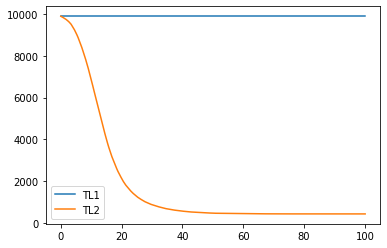

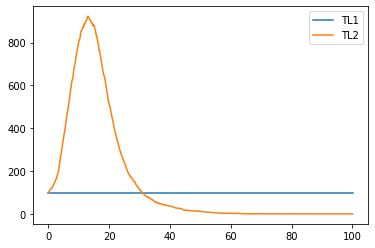

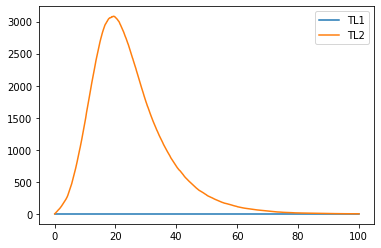

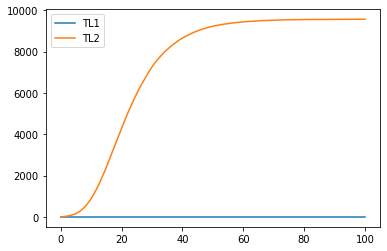

In [16]:
for i in range(1,5):
    plt.plot(tl_plot1[:,0],tl_plot1[:,i],label="TL1")
    plt.plot(tl_plot2[:,0],tl_plot2[:,i],label="TL2")
#     plt.plot(g_plots[:,0],g_plots[:,i],label="GIL")
#     plt.xlim(0,8)
    plt.legend()
    plt.show()
?np.dot